In [2]:
import mlflow
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from umap import UMAP

import graph_reinforcement_learning_using_blockchain_data as grl
from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

2025-05-04 10:52:31.589 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:12 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


True

In [5]:
dataset = torch.load(config.FLASHBOTS_Q2_DATA_DIR / "state_graphs.pt", weights_only=False)
max_feats_len = 0

for vals in dataset.values():
    for graphs in vals:
        if graphs.x.shape[1] > max_feats_len:
            max_feats_len = graphs.x.shape[1]

for vals in dataset.values():
    for graphs in vals:
        graphs.x = grl.pad_features(graphs.x, max_feats_len)

data_list = [d for sublist in dataset.values() for d in sublist]

data_loader = DataLoader(
    data_list, batch_size=256, shuffle=False, exclude_keys=["account_mapping"], drop_last=False
)

In [6]:
model_uri = "mlflow-artifacts:/330930495026013213/1f3f3d97f6a14569b9f2f285c5a98bb4/artifacts/model"
model_dgi = mlflow.pytorch.load_model(model_uri)

In [7]:
model_uri = "mlflow-artifacts:/748752183556303764/465d6f94d00b4fe2bef4d8885ed7be39/artifacts/model"
model_supervised = mlflow.pytorch.load_model(model_uri)

In [8]:
model_uri = "mlflow-artifacts:/132032870842317128/ba4bedca3761489498f42f57c3986752/artifacts/model"
model_pre_trained = mlflow.pytorch.load_model(model_uri)

In [14]:
def unsup_embeddings(model, data_loader):
    model.eval()
    unsup_list, y_list = [], []
    device = torch.device("mps")
    with torch.no_grad():
        for data in tqdm(data_loader):
            data = data.to(device)

            z_nodes = model.encoder(data)
            unsup_emb = global_mean_pool(z_nodes, data.batch)

            unsup_list.append(unsup_emb.cpu())
            y_list.append(data.y.cpu())
    return unsup_list, y_list


def embeddings(model, data_loader):
    model.eval()
    embeddings_list, y_list = [], []
    device = torch.device("mps")
    with torch.no_grad():
        for data in tqdm(data_loader):
            data = data.to(device)
            _, embeddings = model(data, return_embeddings=True)
            embeddings_list.append(embeddings.cpu())
            y_list.append(data.y.cpu())

    return embeddings_list, y_list

In [17]:
X_sup, y_sup = embeddings(model_supervised, data_loader)
X_sup = torch.cat(X_sup).numpy()
y_sup = torch.cat(y_sup).numpy()

100%|██████████| 583/583 [00:09<00:00, 59.77it/s]


In [18]:
X_pre_trained, y_pre_trained = embeddings(model_supervised, data_loader)
X_pre_trained = torch.cat(X_pre_trained).numpy()
y_pre_trained = torch.cat(y_pre_trained).numpy()

100%|██████████| 583/583 [00:09<00:00, 60.65it/s]


In [19]:
scaler = StandardScaler()
X_scaled_sup = scaler.fit_transform(X_sup)
X_scaled_pre_trained = scaler.fit_transform(X_pre_trained)

In [31]:
tsne = TSNE(
    n_components=2,
    perplexity=30,  # ↔ neighbourhood size (5-50 typical)
    learning_rate='auto',  # lets sklearn pick a good value
    init='pca',  # better convergence than random
    random_state=0,
)
X_tsne = tsne.fit_transform(X_scaled)

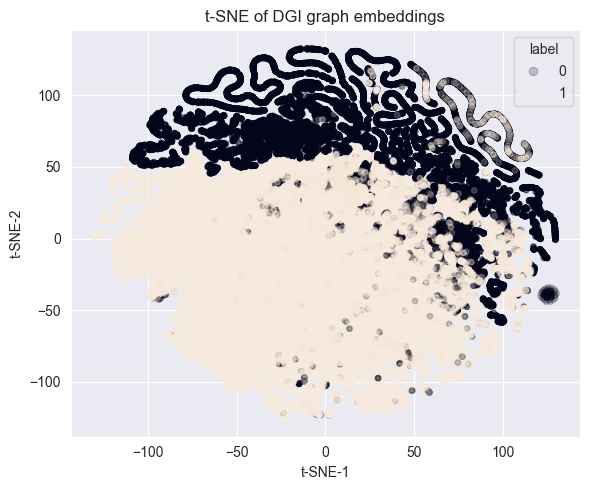

In [34]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=15, alpha=0.2)
plt.title("t-SNE of DGI graph embeddings")
plt.xlabel("t-SNE-1");
plt.ylabel("t-SNE-2")
plt.legend(*scatter.legend_elements(), title="label")
plt.tight_layout();
plt.show()

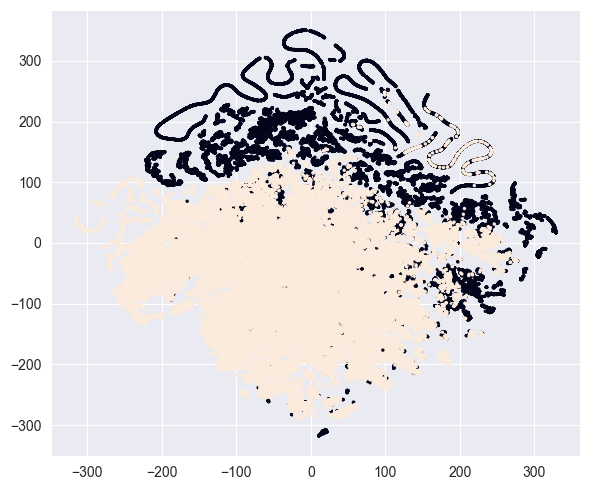

In [10]:
# 2. reduce to ~50 dims first  (faster & denoises)
X_pca = PCA(n_components=50, random_state=42).fit_transform(X_scaled)

# 3. t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    max_iter=5000,
    n_iter_without_progress=300,
    random_state=42,
)
X_tsne = tsne.fit_transform(X_pca)

# 4. plot with tiny opaque dots
plt.figure(figsize=(6, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=6, edgecolors='none')
plt.tight_layout();
plt.show()

In [29]:
def plot_umap(X, y, title):
    reducer = UMAP(
        n_components=2,
        n_neighbors=15,  # local/global trade-off (5–50 typical)
        min_dist=0.3,
        n_epochs=500,
        metric="euclidean",
        random_state=42,
    )
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(6, 5))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=6, edgecolors='none')
    plt.title(title)
    plt.xlabel("UMAP-1");
    plt.ylabel("UMAP-2")
    plt.tight_layout();
    plt.show()
    return X_umap


/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


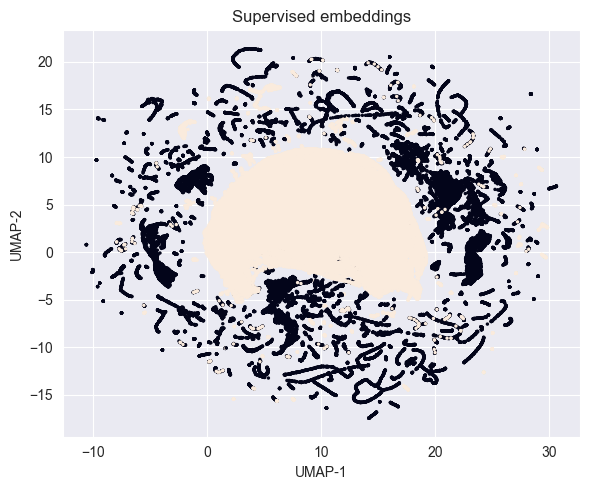

In [30]:
X_umap_sup = plot_umap(X_scaled_sup, y_sup, "Supervised embeddings")

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


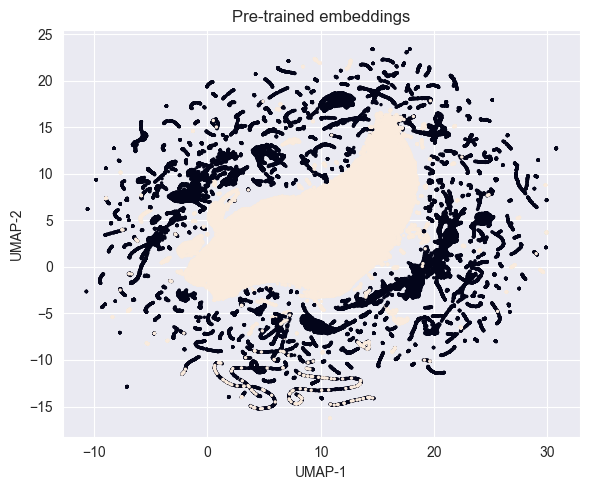

In [31]:
X_umap_pre_trained = plot_umap(X_scaled_pre_trained, y_pre_trained, "Pre-trained embeddings")

In [52]:
def prettifier(X_umap, y):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import cm  # colour maps


    marker_size = 14
    alpha = 0.5
    background = "#F6F7FB"
    grid_color = "#DDE1E8"
    palette_name = "Pai"


    labels = np.unique(y)
    palette = cm.get_cmap(palette_name, len(labels))(range(len(labels)))

    markers = ["o", "s", "D", "^", "v", "P", "X"]  # one per class if you like

    fig, ax = plt.subplots(figsize=(6, 5), facecolor=background)
    ax.set_facecolor(background)
    ax.grid(ls="--", lw=0.4, color=grid_color)

    for i, lab in enumerate(labels):
        idx = y == lab
        ax.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            s=marker_size,
            c=[palette[i]],
            marker=markers[i % len(markers)],
            edgecolors="none",
            alpha=alpha,
            label=f"class {lab}",
        )

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title("UMAP of supervised embeddings")
    ax.legend(frameon=False, fontsize=9, markerscale=1.5, loc="upper right")
    plt.tight_layout()
    plt.show()

/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_10189/2244434616.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap(palette_name, len(labels))(range(len(labels)))


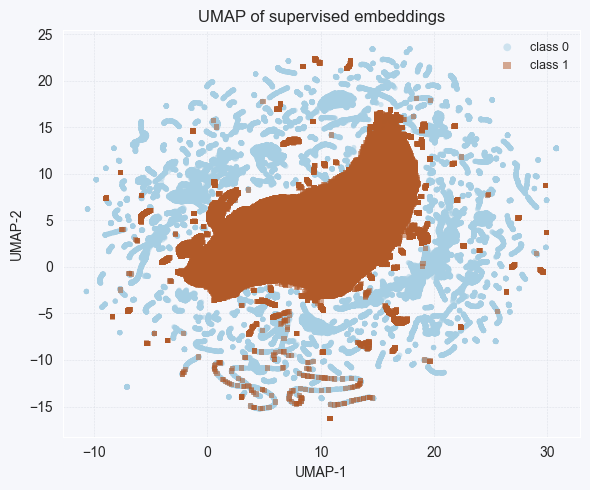

In [53]:
prettifier(X_umap_pre_trained, y_pre_trained)

/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_10189/2244434616.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap(palette_name, len(labels))(range(len(labels)))


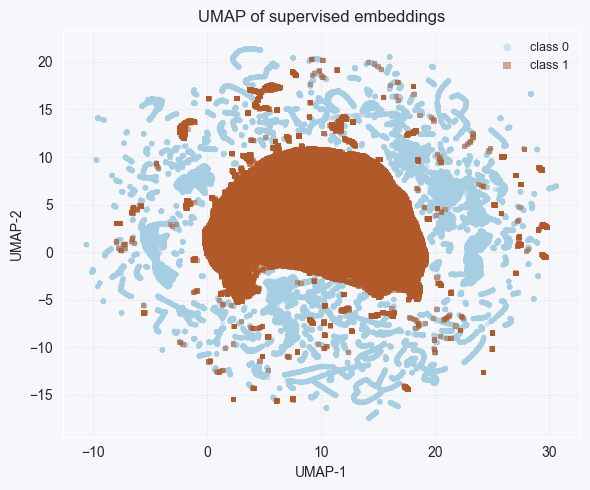

In [54]:
prettifier(X_umap_sup, y_sup)